# Инструменты для работы с языком 

## Задача: классификация твитов по тональности

У нас есть датасет из твитов, про каждый указано, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску.

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [230]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
import nltk
from nltk import ngrams
from nltk import collocations 
from nltk.corpus import stopwords
import warnings
from collections import Counter
from pymorphy2 import MorphAnalyzer
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D, GRU, LSTM, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
warnings.filterwarnings(action='ignore')

In [2]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = pd.concat([positive, negative]).reset_index(drop=True)

In [3]:
positive.shape, negative.shape, df.shape

((114911, 2), (111923, 2), (226834, 2))

In [4]:
df.tail()

,text,label
226829,Но не каждый хочет что то исправлять:( http://...,negative
226830,скучаю так :-( только @taaannyaaa вправляет мо...,negative
226831,"Вот и в школу, в говно это идти уже надо(",negative
226832,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
226833,Такси везет меня на работу. Раздумываю приплат...,negative


In [5]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

## Baseline: классификация необработанных n-грамм

In [6]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train) # bow -- bag of words (мешок слов)

In [16]:
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

LogisticRegression(random_state=42)

In [8]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.76      0.76      0.76     28095
    positive       0.76      0.77      0.76     28614

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



Baseline готов

### Предобработка данных

In [54]:
# выбираем кастомную пунктуацию (оставляет символы скобок, чтобы точнее классифицировать положительные и отрицательные твиты)
punctuation = '!"#$%&\'*+,-./:;<=>?@[\\]^_`{|}~'

In [55]:
# формируем список из стоп-слов и пунктуации
noise = stopwords.words('russian') + list(punctuation)

In [183]:
# делаем класс токенайзер с лемматизацией
class LemmaTokenizer:
    def __init__(self):
        self.analyzer = MorphAnalyzer(lang='ru')
    def __call__(self, doc):
        return [self.analyzer.parse(word)[0].normal_form for word in nltk.word_tokenize(doc, language='russian')]

In [57]:
# подготовим лемматизатор
pymorphy2_analyzer = MorphAnalyzer(lang='ru')

def get_lemma(word):
    return pymorphy2_analyzer.parse(word)[0].normal_form

In [96]:
# посмотрим на частность слов без шума
corpus = [get_lemma(token)
          for tweet in df.text 
          for token in nltk.word_tokenize(tweet, language='russian') 
          if token not in noise]
print(len(corpus))
corpus[:10]

2411413


['first_timee',
 'школотый',
 'поверь',
 'самый',
 'd',
 'общество',
 'профилировать',
 'предмет',
 'тип',
 ')']

## Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

In [138]:
# посмотрим на частность слов, чтобы определить высокочастотные, низкочастотные и токены со средней частотой
freq_dict = Counter(corpus)
freq_dict_sorted = sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('(', 212404),
 (')', 194005),
 ('rt', 38111),
 ('http', 32998),
 ('...', 22363),
 ('это', 20044),
 ('я', 17240),
 ('d', 16595),
 ("''", 12478),
 ('хотеть', 11697)]

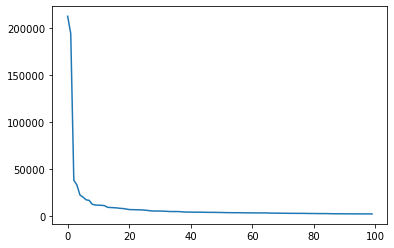

In [139]:
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

Видим очень сильное падение частоты уже к первым 20 самым высокочастотным словам.

Посмотрим на квантили, чтобы выбрать зону отсечки

In [140]:
print({'quantile_' + str(quan / 100): pd.Series(freq_dict.values()).quantile(quan / 100) for quan in range(5, 100, 5)})

{'quantile_0.05': 1.0, 'quantile_0.1': 1.0, 'quantile_0.15': 1.0, 'quantile_0.2': 1.0, 'quantile_0.25': 1.0, 'quantile_0.3': 1.0, 'quantile_0.35': 1.0, 'quantile_0.4': 1.0, 'quantile_0.45': 1.0, 'quantile_0.5': 1.0, 'quantile_0.55': 1.0, 'quantile_0.6': 1.0, 'quantile_0.65': 1.0, 'quantile_0.7': 2.0, 'quantile_0.75': 2.0, 'quantile_0.8': 2.0, 'quantile_0.85': 3.0, 'quantile_0.9': 5.0, 'quantile_0.95': 11.0}


In [147]:
# посмотрим на частоту топ-100
list(freq_dict_sorted)[100][1]

2194

Подавляющее большинство (более 90 %) токенов встречаются не более 5 раз. Их и будем относить к низкочастотным.

К высокочастотным отнесем встречающиеся более 2000 раз (чуть больше чем топ-100 слов).

Остальные к среднечастотным.

In [165]:
# высокочастотные токены
high_freq_list = [word[0] for word in freq_dict_sorted if word[1] > 2000]
high_freq_list

['(',
 ')',
 'rt',
 'http',
 '...',
 'это',
 'я',
 'd',
 "''",
 'хотеть',
 '``',
 '..',
 'день',
 'ты',
 'такой',
 'сегодня',
 'а',
 'быть',
 'мой',
 'очень',
 'знать',
 'просто',
 'мочь',
 'всё',
 'год',
 'весь',
 'человек',
 'любить',
 'и',
 'новый',
 'завтра',
 'не',
 '—',
 'свой',
 'вообще',
 'один',
 'хороший',
 'делать',
 'спасибо',
 'в',
 'ну',
 'смотреть',
 'блин',
 'сказать',
 'думать',
 'который',
 'как',
 'кто',
 'время',
 'идти',
 'почему',
 'говорить',
 'спать',
 'что',
 'дом',
 'у',
 '....',
 'ещё',
 'самый',
 'сидеть',
 'мы',
 'друг',
 'пойти',
 'писать',
 'утро',
 'сделать',
 'школа',
 'жизнь',
 'но',
 'настроение',
 'сам',
 '2',
 'первый',
 'ждать',
 'с',
 'тот',
 'вот',
 'мама',
 'час',
 '3',
 'наш',
 'какой',
 'болеть',
 'твой',
 'любимый',
 'написать',
 'хотеться',
 'этот',
 'работа',
 'видеть',
 'посмотреть',
 'ночь',
 'пока',
 'никто',
 'что-то',
 'на',
 'прийти',
 'последний',
 'понять',
 'стать',
 'добрый',
 'дело',
 'так',
 'купить',
 'да',
 'понимать',
 'недел

In [167]:
# среднечастотные токены
med_freq_list = [word[0] for word in freq_dict_sorted if word[1] <= 2000 and word[1] > 5]
med_freq_list

['каждый',
 'давать',
 'нравиться',
 'скучать',
 'нужно',
 'скоро',
 'вчера',
 'забыть',
 'урок',
 'снег',
 'читать',
 'плохо',
 'работать',
 'голова',
 'остаться',
 'сейчас',
 'фильм',
 'вы',
 'хотя',
 'жить',
 'ходить',
 '9',
 'вечер',
 'домой',
 'надеяться',
 'ахи',
 'телефон',
 'жаль',
 'пара',
 'сон',
 'правда',
 'нужный',
 'нг',
 'казаться',
 'он',
 'бля',
 'какой-то',
 'дать',
 'слово',
 '5',
 'равно',
 'парень',
 '4',
 'ахах',
 'второй',
 'маленький',
 'песня',
 'вроде',
 'улица',
 'если',
 'кто-то',
 'твиттер',
 'плохой',
 'увидеть',
 'рука',
 'о_о',
 'пора',
 'место',
 'из-за',
 'другой',
 'пройти',
 'фотка',
 '1',
 'должный',
 'помнить',
 'привет',
 'только',
 'твит',
 'играть',
 'снова',
 'рождение',
 'круто',
 'новогодний',
 'давно',
 'dd',
 'минута',
 'ехать',
 'решить',
 'х',
 'ранний',
 'девушка',
 'приехать',
 'точно',
 'выходной',
 'выйти',
 'подарок',
 'о',
 'сразу',
 'крутой',
 'кстати',
 ':3',
 'большой',
 'слушать',
 'теперь',
 'бог',
 'к',
 'глаз',
 'класс',
 'бо

In [168]:
# среднечастотные токены
low_freq_list = [word[0] for word in freq_dict_sorted if word[1] <= 5]
low_freq_list

['dyu_bryun',
 'xlesherx',
 'benjamin1610',
 'напролёт',
 'уй',
 'канары',
 'juliacka',
 'de_nativo',
 'шпарить',
 'romashkamarinka',
 'dropbox',
 'напор',
 'джефф',
 'пересказывать',
 'бэтмэн',
 'well',
 'newatosozor',
 'bisheemuu',
 'хол',
 'пророчить',
 'universeismcr',
 'форсквер',
 'бэнг',
 'заклеить',
 'aliya_g_',
 'съёмочный',
 'обходиться',
 'композитор',
 'изобилие',
 'толерантный',
 'або',
 'совместимость',
 'crazypatmofos',
 '.ru',
 '4:0',
 'adler_tasha',
 'anastasiafrost',
 'mvleavivendi',
 'зазаза',
 'мноий',
 'нафоткаться',
 'restivehorse',
 'вибрация',
 'морожок',
 'региться',
 '_anfiska_',
 'задуть',
 'kirio555',
 'вулкан',
 'android045',
 'arina_podmareva',
 'эрэгтэя',
 'morientasperm',
 '10ка',
 'нихуёвый',
 'рублёвка',
 'постебаться',
 'опааа',
 'корочка',
 'шейх',
 'списываться',
 'kafka_frank',
 'mandymandakh',
 'близняшка',
 'yourmonroe',
 'невозмутимый',
 'яковлев',
 'filch_222',
 'ещо',
 'l_enskaya',
 '8-10',
 'еху',
 'valerooooooo',
 'потереть',
 'недотр',
 'fa

In [187]:
# высокочастотные
tokenizer = LemmaTokenizer()
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=tokenizer, stop_words=noise+med_freq_list+low_freq_list)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.98      0.98      0.98     28179
    positive       0.98      0.98      0.98     28530

    accuracy                           0.98     56709
   macro avg       0.98      0.98      0.98     56709
weighted avg       0.98      0.98      0.98     56709



In [188]:
# среднечастотные
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=tokenizer, stop_words=noise+high_freq_list+low_freq_list, max_features=1000)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.59      0.70      0.64     23452
    positive       0.75      0.65      0.70     33257

    accuracy                           0.67     56709
   macro avg       0.67      0.67      0.67     56709
weighted avg       0.68      0.67      0.67     56709



In [189]:
# низкочастотные
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=tokenizer, stop_words=noise+high_freq_list+med_freq_list, max_features=10000)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.04      0.61      0.07      1644
    positive       0.98      0.51      0.67     55065

    accuracy                           0.51     56709
   macro avg       0.51      0.56      0.37     56709
weighted avg       0.95      0.51      0.65     56709



Согласно нашему исследованию, наилучшие результаты у высокочастотных токенов (с результатом F1-score, стремящимся к 1)

Среднечастотные показывают средние результаты.

Низкочастотные показывают средний результат на позитивных твитах, но плохую точность на негативных. 

Таким образом, для данной задачи высокочастотные токены предпочтительнее.

## Задание 2

Найти фичи с наибольшей значимостью, и вывести их

In [190]:
# первые 20
list(freq_dict_sorted)[:20]

[('(', 212404),
 (')', 194005),
 ('rt', 38111),
 ('http', 32998),
 ('...', 22363),
 ('это', 20044),
 ('я', 17240),
 ('d', 16595),
 ("''", 12478),
 ('хотеть', 11697),
 ('``', 11460),
 ('..', 11392),
 ('день', 11001),
 ('ты', 9218),
 ('такой', 9052),
 ('сегодня', 8840),
 ('а', 8634),
 ('быть', 8189),
 ('мой', 7972),
 ('очень', 7430)]

Достаточно закономерно самыми популярными являются смайлики. Хотя попадаются и слова, которые неплохо было бы отфильтровать, например, 'http', 'а', 'd' и т.д.

Посмотрим, как один из супер-значительных токенов справится с классификацией безо всякого машинного обучения:

In [191]:
cool_token = ')'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      0.85      0.92     32794
    positive       0.83      1.00      0.91     23915

    accuracy                           0.91     56709
   macro avg       0.92      0.93      0.91     56709
weighted avg       0.93      0.91      0.91     56709



Справился лучше среднечастотных и низкочастотных токенов.

## Символьные n-граммы

Теперь в качестве фичей используем, например, униграммы символов:

In [192]:
vec = CountVectorizer(analyzer='char', ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.99      1.00      1.00     27844
    positive       1.00      0.99      1.00     28865

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



Данный подход ещё лучше, но с некоторым ущербом для интерпретируемости.

## Задание 3

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

Для сравнения просто отфильтруем шум (без лемматизации), потому что результат униграмм символов мы врядли улучшим.

**Count Vectorizer**

In [195]:
vec = CountVectorizer(ngram_range=(1, 1), stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.75      0.75      0.75     28182
    positive       0.75      0.76      0.75     28527

    accuracy                           0.75     56709
   macro avg       0.75      0.75      0.75     56709
weighted avg       0.75      0.75      0.75     56709



**TF-IDF Vectorizer**

In [196]:
vec = TfidfVectorizer(ngram_range=(1, 1), stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.72      0.76      0.74     26262
    positive       0.78      0.74      0.76     30447

    accuracy                           0.75     56709
   macro avg       0.75      0.75      0.75     56709
weighted avg       0.75      0.75      0.75     56709



**Hashing Vectorizer**

In [202]:
vec = HashingVectorizer(ngram_range=(1, 1), n_features=40000, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.70      0.73      0.71     26603
    positive       0.75      0.72      0.73     30106

    accuracy                           0.72     56709
   macro avg       0.72      0.72      0.72     56709
weighted avg       0.73      0.72      0.72     56709



**NN**

In [233]:
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [234]:
train_data = tf.data.Dataset.from_tensor_slices((x_train.values, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test.values, y_test))

In [235]:
train_data = train_data.batch(16)
test_data = test_data.batch(16)

In [236]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [310]:
vocab_size = 1000
seq_len = 10

vectorize_layer = TextVectorization(
    standardize='lower',
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

In [316]:
embedding_dim=1000

model = Sequential([
    vectorize_layer,
    Embedding(vocab_size, embedding_dim),
    Conv1D(10, (3)),
    GRU(10),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [317]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [318]:
model.fit(train_data, validation_data=test_data, epochs=3)

Epoch 1/3
10633/10633 [==============================] - 103s 9ms/step - loss: 0.5424 - accuracy: 0.6896 - val_loss: 0.5265 - val_accuracy: 0.7005
Epoch 2/3
10633/10633 [==============================] - 101s 10ms/step - loss: 0.5190 - accuracy: 0.7083 - val_loss: 0.5262 - val_accuracy: 0.7022
Epoch 3/3
10633/10633 [==============================] - 100s 9ms/step - loss: 0.5099 - accuracy: 0.7164 - val_loss: 0.5286 - val_accuracy: 0.7031


In [319]:
print(classification_report(model.predict(x_test.values).round(), y_test))

1773/1773 [==============================] - 4s 2ms/step
              precision    recall  f1-score   support

         0.0       0.65      0.72      0.68     24992
         1.0       0.76      0.69      0.72     31717

    accuracy                           0.70     56709
   macro avg       0.70      0.71      0.70     56709
weighted avg       0.71      0.70      0.70     56709



___
С выбранными параметрами лучшие результаты показали CountVectorizer и TfidfVectorizer.

2) подобрать оптимальный размер для hashing векторайзера 

In [321]:
n_features_list = [10, 50, 200, 500, 1000, 5000, 50000, 200000, 500000]
for n_features in n_features_list:
    vec = HashingVectorizer(ngram_range=(1, 1), n_features=n_features, stop_words=noise)
    bow = vec.fit_transform(x_train)
    clf = LogisticRegression(random_state=42)
    clf.fit(bow, y_train)
    pred = clf.predict(vec.transform(x_test))
    print('_' * 50)
    print(f'Результат для {n_features} фичей')
    print(classification_report(pred, y_test))
    print('_' * 50)

__________________________________________________
Результат для 10 фичей
              precision    recall  f1-score   support

           0       0.49      0.54      0.52     25537
           1       0.59      0.55      0.57     31172

    accuracy                           0.54     56709
   macro avg       0.54      0.54      0.54     56709
weighted avg       0.55      0.54      0.54     56709

__________________________________________________
__________________________________________________
Результат для 50 фичей
              precision    recall  f1-score   support

           0       0.57      0.55      0.56     28589
           1       0.56      0.57      0.56     28120

    accuracy                           0.56     56709
   macro avg       0.56      0.56      0.56     56709
weighted avg       0.56      0.56      0.56     56709

__________________________________________________
__________________________________________________
Результат для 200 фичей
              precisi

Прироста метрик при количестве фичей > 50000 практически не происходит. Можно сказать, что оптимальное значение находится в пределах этого значения.

3) убедиться что для сетки нет переобучения

Модель не переобучилась (метрики на трейне и тесте близки, см. пункт 1 задания 3).